## Evolutionary Strategy
一般的遗传算法使用的 DNA 是二进制编码的, 爸妈的 DNA 通过交叉配对, 组成宝宝的 DNA, 宝宝也会通过一定的变异获得新的功能. 但一般的进化策略却有些不同.
![img](https://morvanzhou.github.io/static/results/ML-intro/ES4.png)
爸妈的 DNA 不用再是 01 的这种形式, 我们可以用实数来代替, 咋一看, 觉得牛逼了起来, 因为我们抛开了二进制的转换问题, 从而能解决实际生活中的很多由实数组成的真实问题.
遗传算法中简单的翻牌做法貌似在这里行不通. 不过进化策略中的另外一个因素起了决定性的作用. 这就是变异强度. 简单来说, 我们将爸妈遗传下来的值看做是正态分布的平均值, 再在这个平均值上附加一个标准差, 我们就能用正态分布产生一个相近的数了. 比如在这个8.8位置上的变异强度为1, 我们就按照1的标准差和8.8的均值产生一个离8.8的比较近的数, 比如8.7. 然后对宝宝每一位上的值进行同样的操作. 就能产生稍微不同的宝宝 DNA 啦.

* 我们总结一下, 在进化策略中, 可以有两种遗传性系被继承给后代, 一种是记录所有位置的均值, 一种是记录这个均值的变异强度, 有了这套体系, 我们就能更加轻松自在的在实数区间上进行变异了. 这种思路甚至还能被用在神经网络的参数优化上, 因为这些参数本来就是一些实数. 在之后的视频中我们会继续提到当今比较流行的将人工神经网络结合上遗传算法或者进化策略的方法.

>**在程序里生宝宝, 杀死不乖的宝宝, 让乖宝宝继续生宝宝**


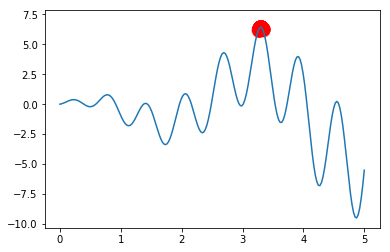

In [1]:

"""
The Evolution Strategy can be summarized as the following term:
{mu/rho +, lambda}-ES
Here we use following term to find a maximum point.
{n_pop/n_pop + n_kid}-ES
Visit my tutorial website for more: https://morvanzhou.github.io/tutorials/
"""
import numpy as np
import matplotlib.pyplot as plt

DNA_SIZE = 1             # DNA (real number)
DNA_BOUND = [0, 5]       # solution upper and lower bounds
N_GENERATIONS = 200
POP_SIZE = 100           # population size
N_KID = 50               # n kids per generation


F = lambda x:np.sin(10*x)*x + np.cos(2*x)*x

def get_fitness(pred): return pred.flatten()

def make_kid(pop,n_kid):
    # generate empty kid holder
    kids = {'DNA':np.empty((n_kid,DNA_SIZE))}
    kids['mut_strength'] = np.empty_like(kids['DNA'])
    for kv, ks in zip(kids['DNA'],kids['mut_strength']):
        # crossover (roughly half p1, half p2)
        p1, p2 = np.random.choice(np.arange(POP_SIZE),size=2,replace=False)
        cp = np.random.randint(0,2,DNA_SIZE,dtype=np.bool)
        kv[cp] = pop['DNA'][p1,cp]
        kv[~cp] = pop['DNA'][p2,~cp]
        ks[cp] = pop['DNA'][p2,cp]
        ks[~cp] = pop['DNA'][p2,~cp]

        # mutate (change DNA based on normal distribution)
        ks[:] = np.maximum(ks + (np.random.rand(*ks.shape)-0.5),0.) # must>0
        kv += ks* np.random.randn(*kv.shape)
        kv[:] = np.clip(kv, *DNA_BOUND) #low & high bound
    return kids

def kill_bad(pop,kids):
    for key in ['DNA','mut_strength']:
        pop[key] = np.vstack((pop[key],kids[key]))

    fitness = get_fitness(F(pop['DNA']))
    idx = np.arange(pop['DNA'].shape[0])
    good_idx = idx[fitness.argsort()][~POP_SIZE:]
    for key in ['DNA','mut_strength']:
        pop[key] = pop[key][good_idx]
    return pop 

pop = dict(DNA=5* np.random.rand(1,DNA_SIZE).repeat(POP_SIZE,axis=0),
    mut_strength=np.random.rand(POP_SIZE,DNA_SIZE))

plt.ion()
x = np.linspace(*DNA_BOUND,200)
plt.plot(x,F(x))

for _ in range(N_GENERATIONS):
#     if 'sca' in globals(): sca.remove()
#     sca = plt.scatter(pop['DNA'],F(pop['DNA']),s=200,lw=0,c='r',alpha=0.5)
#     plt.pause(0.1)

    kids = make_kid(pop,N_KID)
    pop = kill_bad(pop, kids)

# plt.ioff();
sca = plt.scatter(pop['DNA'],F(pop['DNA']),s=200,lw=0,c='r',alpha=0.5)
plt.show()

# ES的不同形式

## $(\mu/\rho\ +,\ \lambda)$-ES : 
$\mu$是population的数量，$\rho$是从population中取出的个数，$\lambda$ 是生成的宝宝数; `+`和 `,` 是生存形式：如果采用的是 “+” 形式的, 就是使用将 ρ + λ 混合起来进行适者生存, 如果是 “,” 形式, 那么就是只使用 λ 进行适者生存.
### (1+1)-ES:
(1+1)-ES 是 ES 进化策略的一种形式, 也是众多形式中比较方便有效的一种. 接下来我们来细说他们的类别. 如果要我用一句话来概括 (1+1)-ES: 一个爸爸和一个孩子的战争. Perporties:
* 有一个爸爸;
* 根据爸爸变异出一个宝宝;
* 在爸爸和宝宝中选好的那个变成下一代爸爸.

In [2]:
DNA_SIZE = 1             # DNA (real number)
DNA_BOUND = [0, 5]       # solution upper and lower bounds
N_GENERATIONS = 200
MUT_STRENGTH = 5.        # initial step size (dynamic mutation strength)

In [3]:
def make_kid_11(parent):
    #no crossover just mutate
    k = parent + MUT_STRENGTH * np.random.randn(DNA_SIZE)
    k = np.clip(k, *DNA_BOUND)
    return k

In [7]:
def kill_bad_11(parent, kid):
    global MUT_STRENGTH
    fp = get_fitness(F(parent))[0]
    fk = get_fitness(F(kid))[0]
    p_target = 1/5
    if fp < fk:     # kid better than parent
        parent = kid
        ps = 1.     # kid win -> ps = 1 (successful offspring)
    else:
        ps = 0.
    # adjust global mutation strength
    MUT_STRENGTH *= np.exp(1/np.sqrt(DNA_SIZE+1) * (ps - p_target)/(1 - p_target))
    return parent

### MUT_STRENGTH:
在 kill_bad 中, 我们选择更为适合的, 不管是爸爸还是孩子, 只要是适合的就留下, 不适合的杀掉. 但是还有注意的一点是, 在这一步我们还要对 MUT_STRENGTH 进行一点改变. 改变的方法遵循了 ** *1/5 successful rule* **. 这个方法是 ES 的开山鼻祖提出来的. 文献在这:

Rechenberg, I. 1973. Evolutionsstrategie – Optimierung technischer Systeme nach Prinzipien der biologischen Evolution, Frommann-Holzboog.

[Tutorials](https://www.lri.fr/~hansen/gecco2011-CMA-ES-tutorial.pdf)
![img](https://morvanzhou.github.io/static/results/evolutionary-algorithm/3-2-1.png)
图中的意思是, 还没到收敛的时候(上面左图), 我们增大 MUT_STRENGTH, 如果已经快到收敛了(上右图), 我们就减小 MUT_STRENGTH. 那如何判断是否快到收敛没呢, 就是如果有1/5的变异比原始的 parent 好的话, 就是快收敛了(像上右图). 在上左图中, 有一半比原始 parent 好, 一半比较差, 所以还没到收敛. 在上面提到的课件中, 用一个公式就能概括这种1/5关系.
![formula](https://morvanzhou.github.io/static/results/evolutionary-algorithm/3-2-2.png)

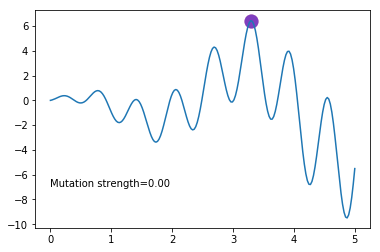

In [47]:
parent = 5 * np.random.rand(DNA_SIZE)   # parent DNA

plt.ion()       # something about plotting
x = np.linspace(*DNA_BOUND, 200)

for _ in range(N_GENERATIONS):
    # ES part
    kid = make_kid_11(parent)
    py, ky = F(parent), F(kid)       # for later plot
    parent = kill_bad_11(parent, kid)

    # something about plotting
plt.cla()
plt.scatter(parent, py, s=200, lw=0, c='red', alpha=0.5,)
plt.scatter(kid, ky, s=200, lw=0, c='blue', alpha=0.5)
plt.text(0, -7, 'Mutation strength=%.2f' % MUT_STRENGTH)
plt.plot(x, F(x));

plt.ioff(); plt.show()

PS. 这种方法很可能会陷入 local maxima~

# Natural Evolution Strategy (NES)
Natural ES 后面简称 NES, 应该就是算一种用适应度诱导的梯度下降法, 如果要我用一句话来概括 NES:** 生宝宝, 用好宝宝的梯度辅助找到前进的方向 **

## Algorithm
![algo](https://morvanzhou.github.io/static/results/evolutionary-algorithm/3-3-1.png)
ps. $\pi$ 泊松分布~x=k的概率是:P(X=k)=e^(-λ)*[(λ^k)/(k!)], (k≥0)

宝宝们的梯度是这个 $\nabla_{\theta}\log{\pi}(z_k\mid\theta)$ 加上这些宝宝们的 fitness $f(z_k)$, 用梯度乘以 fitness 就是说, 加大力度往带来好 fitness 的梯度下降. 所以之后的宝宝们就会越来越多的下降到最优点啦. 那么我们要梯度下降的参数则是那些正态分布的均值和均方差.

NES 的方法其实和强化学习中 Policy Gradient 的方法非常接近. 简单来概括一下它们的不同: 在行为的策略上, PG 是扰动 Action, 不同的 action 带来不同的 reward, 通过 reward 大小对应上 action 来计算 gradient, 再反向传递 gradient. 但是 ES 是扰动 神经网络中的 Parameters, 不同的 parameters 带来不同的 reward, 通过 reward 大小对应上 parameters 来按比例更新原始的 parameters.

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance 

DNA_SIZE = 2         # parameter (solution) number
N_POP = 20           # population size
N_GENERATION = 100   # training step
LR = 0.02            # learning rate

get_fitness = lambda pred: -((pred[:,0])**2+pred[:,1]**2)

In [ ]:
# build multivariate distribution
mean = tf.Variable(tf.random_normal([2,],13.,1.),dtype=tf.float32)
cov = tf.Variable(5.*tf.eye(DNA_SIZE),dtype=tf.float32) # eye is  Identity Matrix
mvn = MultivariateNormalFullCovariance(loc=mean, covariance_matrix=cov)
make_kid = mvn.sample(N_POP) # sampling operation

我们用 mean, cov 当作要学的变量, 放入 MultivariateNormalFullCovariance 中. 这时的 mvn 就是这个多变量正态分布啦. 采样的时候呢, 我们就能用 mvn.sample(N_POP). 记住, make_kid 目前只是在计算图纸上的功能, 还没被运行, 之后调用的时候才被运行.

In [ ]:
tfkids_fit = tf.placeholder(tf.float32, [N_POP, ])
tfkids = tf.placeholder(tf.float32, [N_POP, DNA_SIZE])
loss = -tf.reduce_mean(mvn.log_prob(tfkids)*tfkids_fit) # log prob * fitness
train_op = tf.train.GradientDescentOptimizer(LR).minimize(loss) # compute and apply gradients for mean and cov

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#plt
n = 300
x = np.linspace(-20, 20, n)
X, Y = np.meshgrid(x, x)
Z = np.zeros_like(X)
for i in range(n):
    for j in range(n):
        Z[i, j] = get_fitness(np.array([[x[i], x[j]]]))
plt.contourf(X, Y, -Z, 100, cmap=plt.cm.rainbow); plt.ylim(-20, 20); plt.xlim(-20, 20); plt.ion()

#training
for g in range(N_GENERATION):
    kids = sess.run(make_kid)
    kids_fit = get_fitness(kids)
    sess.run(train_op,feed_dict={tfkids_fit:kids_fit,tfkids:kids})

        # plotting update
    if 'sca' in globals(): sca.remove()
    sca = plt.scatter(kids[:, 0], kids[:, 1], s=30, c='k');plt.pause(0.01)

print('Finished'); plt.ioff(); plt.show()

![img](https://morvanzhou.github.io/static/results/evolutionary-algorithm/3-3-0.gif)